# Tests output ForecasterAutoregMultiseries (0.12.0)

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
print(str(Path.cwd().parent.parent))

# Data management
# ==============================================================================
import numpy as np
import pandas as pd
import joblib

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
set_dark_theme()

# Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import ParameterGrid
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

# Others
# ==============================================================================
import warnings
import sys

print(f"Python version: {sys.version}")
print(f"skforecast version: {skforecast.__version__}")
print(f"lightgbm version: {lightgbm.__version__}")
print(f"sklearn version: {sklearn.__version__}")

c:\Users\Joaquín Amat\Documents\GitHub\skforecast


Python version: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 17:20:38) [MSC v.1916 64 bit (AMD64)]
skforecast version: 0.12.0
lightgbm version: 4.1.0
sklearn version: 1.3.2


In [ ]:
#  todo: media ponderada

# Tes utitario para verificar que nada cambia

# Test series of different lengths and different exogenous variables per series

In [18]:
# Load time series of multiple lengths
# ==============================================================================
# series_dict = joblib.load('sample_multi_series.joblib')
# exog_dict = joblib.load('sample_multi_series_exog.joblib')

series = pd.read_csv('sample_multi_series.csv')
exog = pd.read_csv('sample_multi_series_exog.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])


series_dict = series_long_to_dict(
    data = series,
    series_id = 'series_id',
    index = 'timestamp',
    values = 'value',
    freq = 'D'
)

exog_dict = exog_long_to_dict(
    data = exog,
    series_id = 'series_id',
    index = 'timestamp',
    freq = 'D'
)

exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])
exog_dict['id_1003'] = exog_dict['id_1003'].drop(columns=['cos_day_of_week'])

series_df = pd.DataFrame(series_dict)

In [29]:
# Partition data in train, validation and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'

series_df_train   = series_df.loc[: end_train, :].copy()
series_df_test    = series_df.loc[end_train:, :].copy()
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

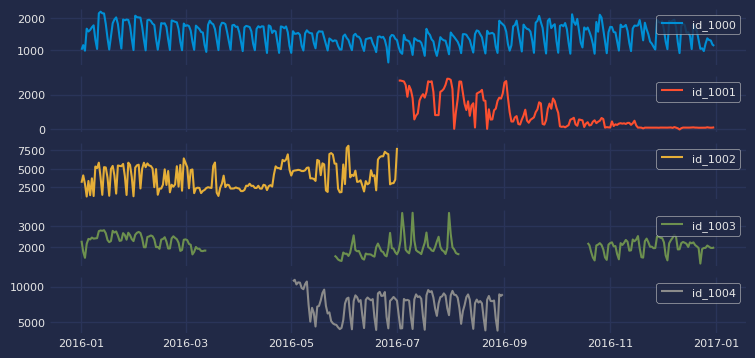

In [30]:
# Plot series
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.values()):
    axs[i].plot(s, label=s.name, color=colors[i])
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [31]:
# Description of each partition
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(
            f"\tTrain: len={len(series_dict_train[k])}, {series_dict_train[k].index[0]}"
            f" --- {series_dict_train[k].index[-1]}"
        )
    except:
        print(f"\tTrain: len=0")
    try:
        print(
            f"\tTest : len={len(series_dict_test[k])}, {series_dict_test[k].index[0]}"
            f" --- {series_dict_test[k].index[-1]}"
        )
    except:
        print(f"\tTest : len=0")

id_1000:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1001:
	Train: len=30, 2016-07-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1002:
	Train: len=183, 2016-01-01 00:00:00 --- 2016-07-01 00:00:00
	Test : len=0
id_1003:
	Train: len=213, 2016-01-01 00:00:00 --- 2016-07-31 00:00:00
	Test : len=153, 2016-08-01 00:00:00 --- 2016-12-31 00:00:00
id_1004:
	Train: len=91, 2016-05-02 00:00:00 --- 2016-07-31 00:00:00
	Test : len=31, 2016-08-01 00:00:00 --- 2016-08-31 00:00:00


In [32]:
# Exogenous variables for each series
# ==============================================================================
for k in series_dict.keys():
    print(f"{k}:")
    try:
        print(f"\t{exog_dict[k].columns.to_list()}")
    except:
        print(f"\tNo exogenous variables")

id_1000:
	['sin_day_of_week', 'cos_day_of_week']
id_1001:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1002:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']
id_1003:
	['sin_day_of_week', 'air_temperature', 'wind_speed']
id_1004:
	['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']


## Series is dataframe (filled with NaNs) and exog is dictionary

In [40]:
# Series is dataframe and exog is dictionary
# ==============================================================================
parmas = {
    'encoding': ['ordinal', 'onehot', 'ordinal_category'],
    'dropna_from_series': [False, True],
}
param_grid = list(ParameterGrid(parmas))

for params in param_grid:
    print(f"Paramns: {params}")
    
    forecaster = ForecasterAutoregMultiSeries(
                    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                    lags=14,
                    encoding=params['encoding'],
                    dropna_from_series=params['dropna_from_series'],
                    transformer_series=StandardScaler(),
                    transformer_exog=StandardScaler()          
                )
    forecaster.fit(series=series_df_train, exog=exog_dict_train, suppress_warnings=True)
    predictions_1 = forecaster.predict(steps=5, exog=exog_dict_test)

    forecaster = ForecasterAutoregMultiSeries(
                    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                    lags=14,
                    encoding=params['encoding'],
                    dropna_from_series=params['dropna_from_series'],
                    transformer_series=StandardScaler(),
                    transformer_exog=StandardScaler()          
                )
    forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
    predictions_2 = forecaster.predict(steps=5, exog=exog_dict_test)

    pd.testing.assert_frame_equal(predictions_1, predictions_2)

Paramns: {'dropna_from_series': False, 'encoding': 'ordinal'}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'dropna_from_series': False, 'encoding': 'onehot'}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'dropna_from_series': False, 'encoding': 'ordinal_category'}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1003' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'dropna_from_series': True, 'encoding': 'ordinal'}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'dropna_from_series': True, 'encoding': 'onehot'}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

Paramns: {'dropna_from_series': True, 'encoding': 'ordinal_category'}


/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingV

## Backtesting

/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'air_temperature', 'wind_speed'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:414: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/utils/utils.py:853: MissingE

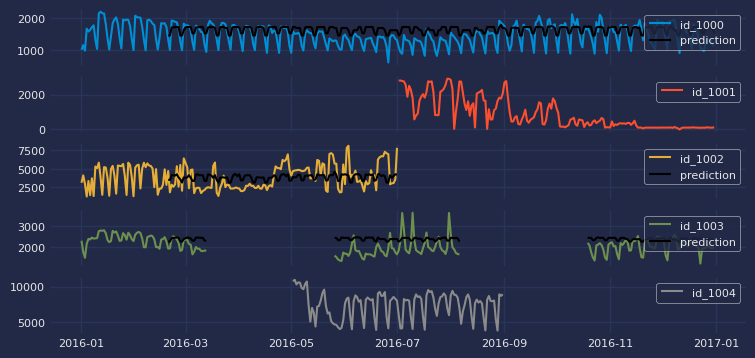

In [45]:
# Test backtesting
# ==============================================================================
params = {
    'refit' : False,
    'fixed_train_size': False,
    'gap': 0
}

forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler(),
    
)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    levels                = None,
    steps                 = 24,
    metric                = ['mean_absolute_error', 'mean_squared_error'],
    initial_train_size    = 50,
    fixed_train_size      = params['fixed_train_size'],
    gap                   = params['gap'],
    allow_incomplete_fold = True,
    refit                 = params['refit'],
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = False,
    suppress_warnings     = True
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label='prediction', color="black")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [44]:
metrics_levels


TODO: media ponderada de las metricas

,levels,mean_absolute_error,mean_squared_error
0,id_1000,253.806754,9.771572e+04
1,id_1001,NaN,NaN
2,id_1002,1419.409603,2.626552e+06
3,id_1003,463.410950,3.042752e+05
4,id_1004,NaN,NaN


## Bayesian Search

In [22]:
# Test Bayesian search
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler()
            )

lags_grid = [
    [5],
    [1, 7, 14]
]

def search_space(trial):
    search_space  = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 25, 50, step=100),
        "max_depth": trial.suggest_int('max_depth', 2, 5),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        'lags' : trial.suggest_categorical('lags', lags_grid)
    }

    return search_space

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning, module='optuna')

    results_search_1, best_trial_1 = bayesian_search_forecaster_multiseries(
        forecaster         = forecaster,
        series             = series_dict,
        exog               = exog_dict,
        search_space       = search_space,
        metric             = 'mean_absolute_error',
        initial_train_size = len(series_train),
        steps              = 10,
        refit              = False,
        n_trials           = 5,
        return_best        = False,
        show_progress      = False,
        verbose            = False
    )

results_search_1


Number of models compared: 5,
         5 bayesian search in each lag configuration.


c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\F

,levels,lags,params,mean_absolute_error,learning_rate,n_estimators,max_depth,subsample,colsample_bytree,lags
4,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.07758424358283758, 'n_esti...",527.801239,0.077584,25,3,0.553252,0.459784,"[1, 7, 14]"
0,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.06107686573608482, 'n_esti...",547.730261,0.061077,25,3,0.458796,0.685920,[5]
1,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.8376388146302433, 'n_estim...",561.434225,0.837639,25,4,0.636652,0.574482,"[1, 7, 14]"
3,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.013372281038573085, 'n_est...",741.762738,0.013372,25,4,0.744081,0.894602,[5]
2,"[id_1000, id_1001, id_1002, id_1003, id_1004]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'learning_rate': 0.005679223741740077, 'n_est...",805.681905,0.005679,25,2,0.578631,0.816597,[5]


## Series is dictionary with NaNs interspersed and exog is dictionary

In [24]:
series_dict['id_1002'].at['2016-02-01'] = np.nan
series_dict['id_1002'].at['2016-05-01'] = np.nan

In [25]:
# Series is dictionary and exog is dictionary
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
                lags=14,
                encoding="ordinal",
                dropna_from_series=False,
                transformer_series=StandardScaler(),            
            )
forecaster.fit(series=series_dict_train, exog=exog_dict_train)
predictions = forecaster.predict(steps=5, exog=exog_dict_val)
predictions

c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\utils\utils.py:850: MissingExo

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1346.526709,2358.795448,2458.275051,8076.922788
2016-08-02,1402.933366,2308.551229,2253.945800,8388.586786
2016-08-03,1426.861295,2196.482721,2160.584136,8141.853450
2016-08-04,1385.295338,2335.597540,2105.835058,8063.913923
2016-08-05,1349.322751,2188.527743,2085.382953,8128.082279


c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:766: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\Joaquín Amat\Documents\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:789: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


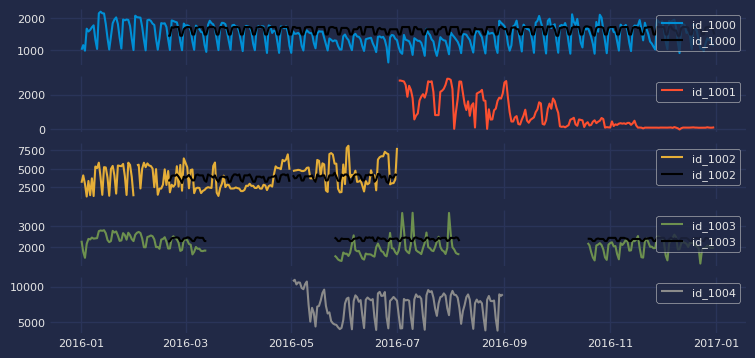

In [26]:
# Test backtesting
# ==============================================================================
params = {
    'refit' : False,
    'fixed_train_size': False,
    'gap': 0
}

forecaster = ForecasterAutoregMultiSeries(
    regressor=LGBMRegressor(n_estimators=10, random_state=123, verbose=-1),
    lags=14,
    encoding="ordinal",
    dropna_from_series=False,
    transformer_series=StandardScaler()
)

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    levels                = None,
    steps                 = 24,
    metric                = ['mean_absolute_error', 'mean_squared_error'],
    initial_train_size    = 50,
    fixed_train_size      = params['fixed_train_size'],
    gap                   = params['gap'],
    allow_incomplete_fold = True,
    refit                 = params['refit'],
    n_jobs                = 'auto',
    verbose               = False,
    show_progress         = False
)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)
for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name, color=colors[i])
    try:
        axs[i].plot(backtest_predictions[s], label=backtest_predictions[s].name, color="black")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)